<h1>자전거 대여 시스템 EDA 및 모델링</h1>

<h3>환경설정</h3>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import platform 
import os # 캐시 삭제를 위해 os 모듈 추가

from matplotlib import  rc
print(plt.rcParams['font.family'])

import platform

# 운영체제에 따라 폰트 설정
if platform.system() == 'Darwin':  # MacOS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  
    rc('font', family='Malgun Gothic')
else:  
    korean_font_families = ['NanumGothic', 'Malgun Gothic', 'AppleGothic', 'NanumBarunGothic', 'sans-serif']
    rc('font', family=korean_font_families)
    print(f"정보: 리눅스 환경에서 폰트 우선순위 목록을 설정했습니다: {korean_font_families}")

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


['sans-serif']


<h3>Description</h3>

 - datetime	자전거 대여 기록의 날짜 및 시간. 예시: 2011-01-01 00:00:00

- season	int	계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)

- holiday	int	공휴일 여부 (0: 평일, 1: 공휴일)

- workingday	int	근무일 여부 (0: 주말/공휴일, 1: 근무일)

- weather	int	날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설)

- temp	float	실측 온도 (섭씨)

- atemp	float	체감 온도 (섭씨)

- humidity	int	습도 (%)

- windspeed	float	풍속 (m/s)

- casual	int	등록되지 않은 사용자의 대여 수

- registered	int	등록된 사용자의 대여 수

- count	int	총 대여 수 (종속 변수)

<h3>데이터 구조파악</h3>

In [3]:

train = pd.read_csv("data/train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [10]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [11]:
#수치형 데이터 통계요약
 #-스케일 파악: 각 변수의 값 범위(최소-최대)를 파악하여 전처리(스케일링)가 필요한지 판단합니다.
 #이상치/편향 확인: 평균($\text{mean}$)과 중앙값($\text{50\%}$)의 차이를 통해 데이터의 분포가 한쪽으로 쏠려 있는지(편향) 또는 극단적인 이상치가 있는지 초기 징후를 파악할 수 있습니다.
 
 # 이부분은 나중에 데이터분석을다시 해보자
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


<h3>결측치 확인</h3>

In [59]:
#결측치가 별견되지 않음
train.info()
train.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<h3>데이터 시각화</h3>

<p>우선 1차적으로 시간기반 대여량이 가장중요한 요소라고 판단됨으로 처음에 시간을중점으로 분석 시작</p>

<h4>1. 시간대별 평균 자전거 대여량<h4>

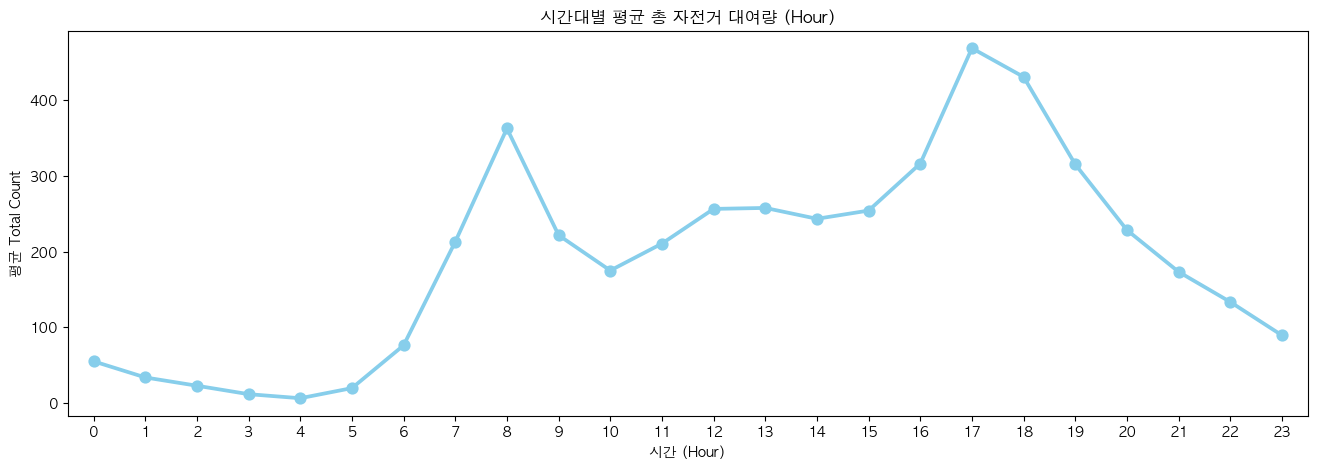

In [60]:
#시간 데이터 추출
train['datetime'] = pd.to_datetime(train['datetime'])
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train['month'] = train['datetime'].dt.month


# 4-1. 시간대(Hour)별 패턴 분석 (총 대여량)
plt.figure(figsize=(16, 5))
sns.pointplot(x='hour', y='count', data=train, color='skyblue', ci=None)
plt.title('시간대별 평균 총 자전거 대여량 (Hour)')
plt.ylabel('평균 Total Count')
plt.xlabel('시간 (Hour)')
plt.show()

<h5>분석</h5>
<p> - 데이터가 6~10시 구간, 16시~19시 구간에 재여량이 많습니다.   </p>
<p> 출퇴근, 혹은 등하교 시간대라 대여량이 급증하는걸로 예상됨<p>
<p> 이구간 데이터수치대로 모델링하면 편하겠지만, 좀더 머신러닝때 정확하게 하기위해 다른데이터를 추가해서 세분화 시킬필요가 있습니다.<p>
<p> 세분화할시 여러가지가 있겠지만 출퇴근이나 등하교에 관련이 가장 클거같으므로 주말과 평일을 데이터를 나누어서 분석해볼필요가 있습니다.<p>
<p> 그전에 registered 컬럼별로 대여량차이가 있는지 확인하고 나눠서 예측할필요가 있습니다.  <p>

<h5>1 - 1. 시간대별 평균 자전거 대여량 회원별로(Registered)<h5>

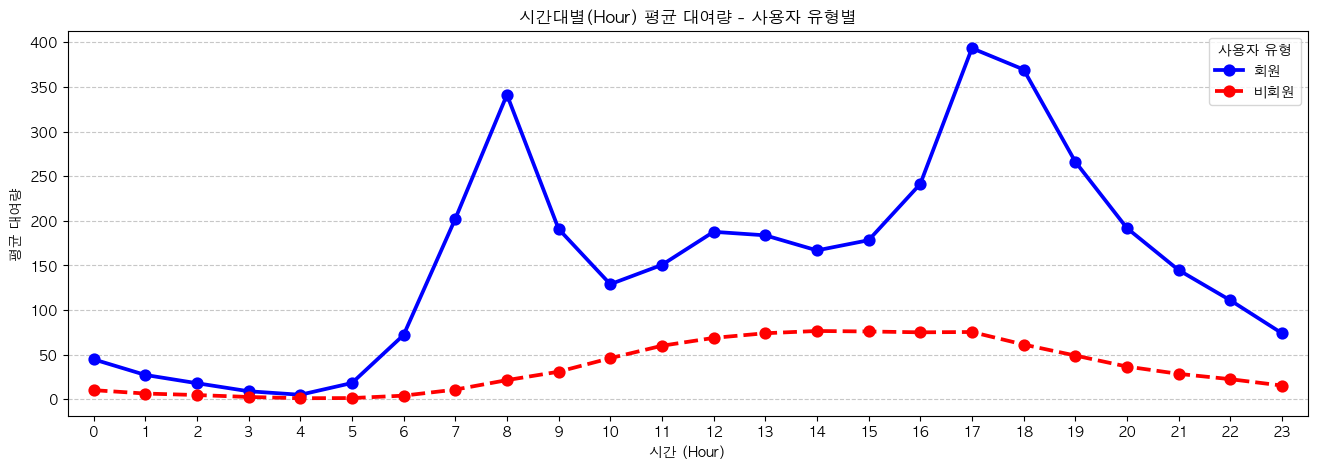

In [61]:
plt.figure(figsize=(16, 5))

# 등록 사용자 (Registered) 시간대별 평균 대여량 (한글 레이블 사용)
sns.pointplot(x='hour', y='registered', data=train, 
              linestyles='-', color='blue', label='회원', ci=None)

# 비등록 사용자 (Casual) 시간대별 평균 대여량 (한글 레이블 사용)
sns.pointplot(x='hour', y='casual', data=train, 
              linestyles='--', color='red', label='비회원', ci=None)

# 그래프 제목 및 축 레이블 설정
plt.title('시간대별(Hour) 평균 대여량 - 사용자 유형별')
plt.ylabel('평균 대여량')
plt.xlabel('시간 (Hour)')

# 범례를 표시합니다.
plt.legend(title='사용자 유형', labels=['회원', '비회원'])

plt.grid(True, axis='y', linestyle='--', alpha=0.7) 
plt.xticks(range(0, 24)) 
plt.show()

<h5>분석</h5>
<p>- 회원/비회원 대여량 차이가 있습니다. 요금제라던지 사용편의성이라던지 확실한 이유가 존재하리라 예측합니다.</p>
<p>- 정확한 데이터를위해 앞으로 필요한경우 나눠서 데이터를예측하고 만약에 큰변동없이 낮은 대여수를 유지한다면 회원,비회원 합쳐서 모델링해도 무방할거라 예측</p>

<h4>2. 요일별 대여량<h4>

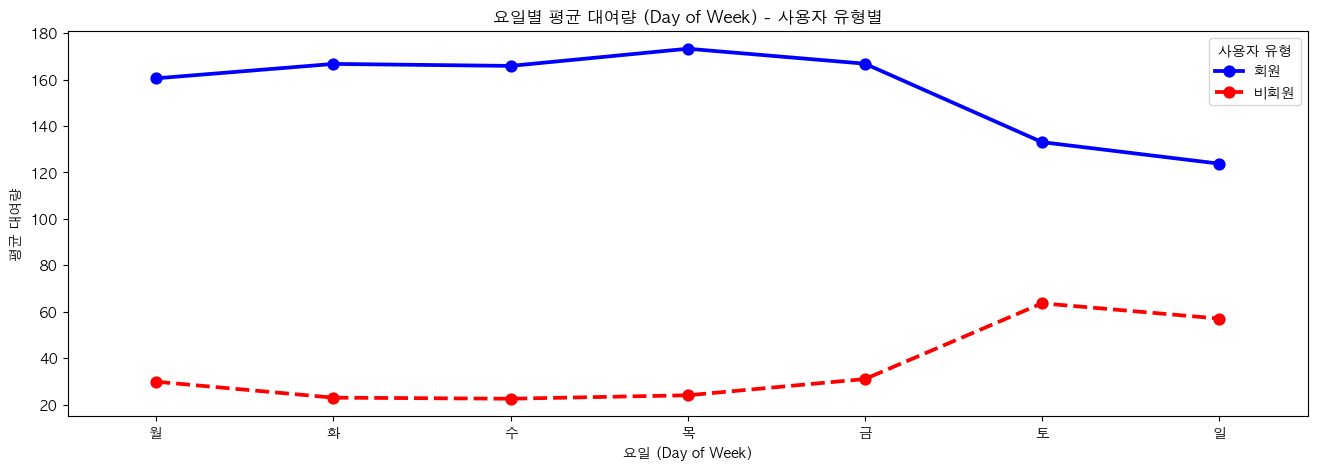

In [62]:

# 4-2. 요일(Day of Week)별 패턴 분석 (등록/비등록 사용자 분리)
plt.figure(figsize=(16, 5))
sns.pointplot(x='dayofweek', y='registered', data=train, linestyles='-', color='blue', label='회원', ci=None)
sns.pointplot(x='dayofweek', y='casual', data=train, linestyles='--', color='red', label='비회원', ci=None)

plt.title('요일별 평균 대여량 (Day of Week) - 사용자 유형별')
plt.gca().set_xticklabels(['월', '화', '수', '목', '금', '토', '일'])
plt.ylabel('평균 대여량')
plt.xlabel('요일 (Day of Week)')
plt.legend(title='사용자 유형')
plt.show()

<h5>분석</h5>
<p>- 회원은 평일,주말 자전거 대여량이 평일은 높고 주말에 낮아지는걸로 보아 시간대별 분석에서 확인했던 출퇴근 시간대의 피크와도 일치합니다. 회원은 일상적인 통근 목적으로 이용하는걸로 예측 </p>
<p>- 비회원이 주말에 3~4배정도 증가하는 이유는 간단한 여행, 여가활동으로 이용을 많이 하는걸 예측합니다. </p>
<p>- 평일과 주말 데이터를 나눠서 데이터를 모델링하는건 긍정적인 요소, 또한 회원별 비회원별 나누는것도 도움이될거라 생각합니다.</p>


<h4>3. 날씨별 평균 회원/비회원 대여량<h4>

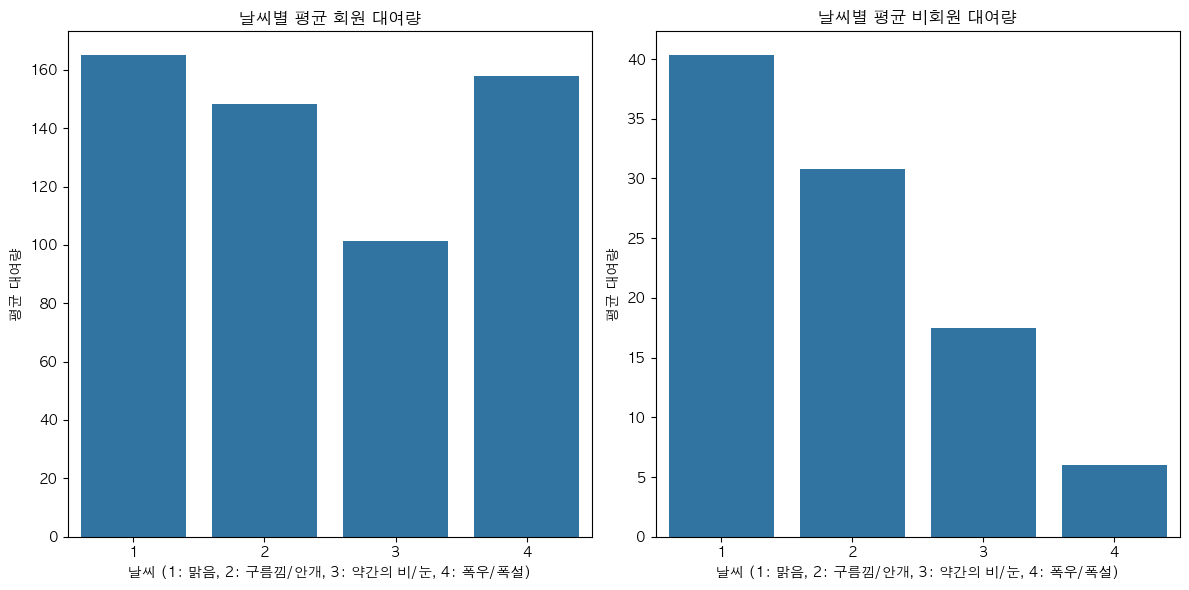

In [63]:
# 날씨(weather)에 따른 회원/비회원 평균 대여량 비교 (막대 그래프)
plt.figure(figsize=(12, 6))

# 등록 사용자 (회원)
plt.subplot(1, 2, 1)
sns.barplot(x='weather', y='registered', data=train, ci=None)
plt.title('날씨별 평균 회원 대여량')
plt.ylabel('평균 대여량')
plt.xlabel('날씨 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설)')

# 비등록 사용자 (비회원)
plt.subplot(1, 2, 2)
sns.barplot(x='weather', y='casual', data=train, ci=None)
plt.title('날씨별 평균 비회원 대여량')
plt.ylabel('평균 대여량')
plt.xlabel('날씨 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설)')

plt.tight_layout() # 그래프 간격 자동 조정
plt.show()

<h3>분석</h3>
<p>- 회원은 날씨가 좋지않아도 출퇴근 및 일상적인 이동을위해 지전거를 이용한다고 예측되는데 다만 폭우 폭설때 데이터량이 줄지않는 이유는 예측에 벗어난 결과 입니다.</p>
<p>- 폭우,폭설땐 오히려 택시나 대중교통 이용이 불가능한경우라 최후의 수단으로 이용되는것 일수도...?</p>
<p>- 반면 비회원은 날씨가 좋을때 급증하고 날씨가 안좋을때 급락하는걸보면 비회원의 간단한 여행, 여가활동으로 인한 데이터예측과 일치 합니다.</p>
<p>- 대여량 예측시 특히 비회원은 weather 데이터도 매우 중요한 요소중 하나</p>

<h4>4. 온도별 대여량 예측<h4>

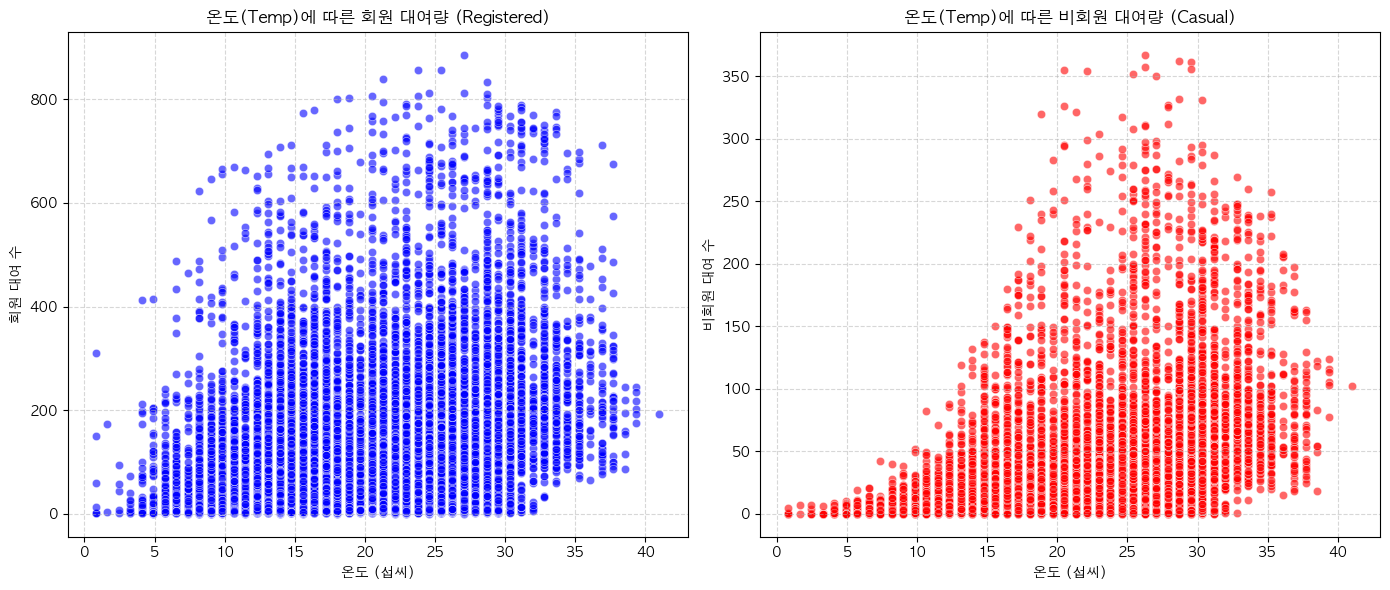

In [64]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='temp', y='registered', data=train, alpha=0.6, color='blue')
plt.title('온도(Temp)에 따른 회원 대여량 (Registered)')
plt.ylabel('회원 대여 수')
plt.xlabel('온도 (섭씨)')
plt.grid(True, linestyle='--', alpha=0.5)

# 2. 비회원 (Casual) 대여량 vs 온도
plt.subplot(1, 2, 2)
sns.scatterplot(x='temp', y='casual', data=train, alpha=0.6, color='red')
plt.title('온도(Temp)에 따른 비회원 대여량 (Casual)')
plt.ylabel('비회원 대여 수')
plt.xlabel('온도 (섭씨)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

<h3>분석</h3>

<p>- 회원은 넓은 범위의 온도에서 높은대여량 유지, 극단적인 기온에선 다른대중교통 이용하는것으로 예측 합니다.</p>
<p>- 비회원은 회원보다 좁은 범위에서 대여량 유지, 여행,여가에 온도는 민감하기때문이라고 예측 합니다.</p>
<p>- 모델링시 온도도 중요한 데이터중 하나<p>

<h4>5. 월별 데이터 분석</h4>

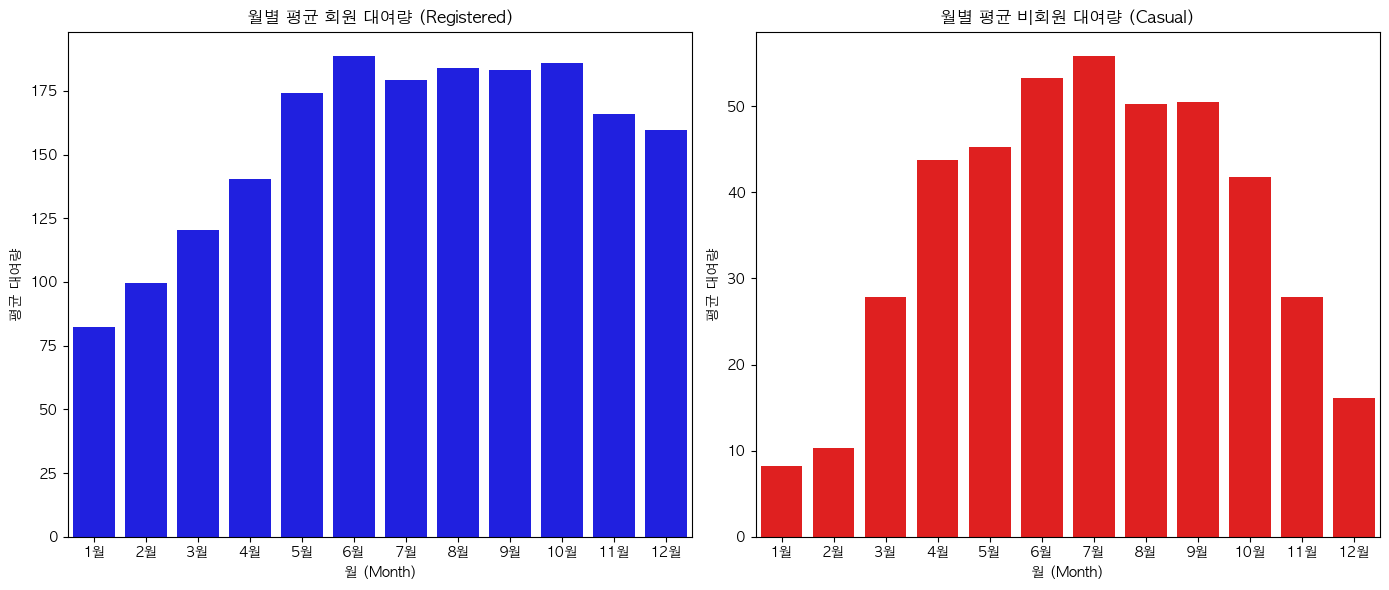

In [65]:
plt.figure(figsize=(14, 6))

# 1. 회원 (Registered) 월별 평균 대여량 (막대 그래프)
plt.subplot(1, 2, 1)
sns.barplot(x='month', y='registered', data=train, color='blue', ci=None)
plt.title('월별 평균 회원 대여량 (Registered)')
plt.ylabel('평균 대여량')
plt.xlabel('월 (Month)')
plt.xticks(range(0, 12), [str(i+1) + '월' for i in range(12)]) 

# 2. 비회원 (Casual) 월별 평균 대여량 (막대 그래프)
plt.subplot(1, 2, 2)
sns.barplot(x='month', y='casual', data=train, color='red', ci=None)
plt.title('월별 평균 비회원 대여량 (Casual)')
plt.ylabel('평균 대여량')
plt.xlabel('월 (Month)')
plt.xticks(range(0, 12), [str(i+1) + '월' for i in range(12)]) 

plt.tight_layout() # 그래프 간격 자동 조정
plt.show()

<h3>분석</h3>

<p>회원은 연중 꾸준하게 이용하는경우가 많음, 낮은온도로인해 일상적인 통근 수요 감소, 혹은 방학</p>
<p>5월부터 ~10월까지는 예측 가능하고 안정적인 수요를 보입니다.</p>
<p>비회원은 계절에 민감한 이용층, 6월~9월에 야외활동이 많은 기간에 수요가 몰립니다. 이기간 주말 및 공휴일에 수요가 폭증할거로 예상<p>

<h3>모델링</h3>
<h3>1.데이터 전처리</h3>

In [17]:

# 모델링
# 데이터준비

train = pd.read_csv('data/train.csv')
   
# 2. datetime 컬럼 변환 및 원본 백업
train['datetime'] = pd.to_datetime(train['datetime'])
    # 이후 시각화 비교를 위해 원본 데이터 백업 
train_original = train.copy()



<h3>2.파생 변수 생성</h3>

In [18]:
# -------------------- 1. 시간 피처 생성 --------------------


# 2. 'datetime' 컬럼을 pandas의 datetime 타입으로 변환
train['datetime'] = pd.to_datetime(train['datetime'])


def create_time_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.dayofweek
    df['quarter'] = df['datetime'].dt.quarter
    
    # 불필요한 datetime 원본 컬럼 제거
    df = df.drop('datetime', axis=1)
    return df

train = create_time_features(train)
print("시간 피처 생성 완료. (year, month, hour, weekday, quarter)")

시간 피처 생성 완료. (year, month, hour, weekday, quarter)


<h3>3.범주형/수치형 피처 처리</h3>

<p>선형모델들은 범주형 피처를 수치화하고 수치형 피처의 스케일을 맞추는 것이 필수</p>
<p>원 핫 인코딩 파이프라인 생성</p>

In [19]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


# 범주형 피처 지정
categorical_features = ['month', 'hour', 'weekday', 'season', 'weather', 'holiday', 'workingday', 'year', 'quarter']

# 원-핫 인코딩 파이프라인 생성 (나머지 컬럼은 유지 'passthrough')
# OneHotEncoder의 handle_unknown='ignore'는 test 데이터에 새로운 범주가 나타나도 오류를 방지합니다.
preprocessor_categories = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# 일단 train 데이터에 적용하여 범주형 피처를 변환합니다.
# 이 단계에서는 아직 수치형 피처의 스케일링을 하지 않고, 범주형 변환만 확인합니다.
train_encoded = preprocessor_categories.fit_transform(train)



<h3>4.피처 분류</h3>
<p>현재 train 데이터에 남아있는 피처들을 수치형과 범주형으로 분류합니다.</p>

In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# ----------------- 피처 목록 재정의 -----------------
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed']
categorical_features = ['month', 'hour', 'weekday', 'season', 'weather', 'holiday', 'workingday', 'year', 'quarter']

# ----------------- 타겟 변수 및 불필요 피처 분리 -----------------
# count, casual, registered는 예측에 사용하지 않고 별도로 분리합니다.
features = train.drop(['casual', 'registered', 'count', 'day'], axis=1) # 'day'는 의미가 적어 제외

# ----------------- 전처리 객체 정의 -----------------
preprocessor = ColumnTransformer(
    transformers=[
        # 1. 수치형 피처: StandardScaler (평균 0, 표준편차 1로 스케일링)
        ('num', StandardScaler(), numerical_features),
        # 2. 범주형 피처: OneHotEncoder (가변수화)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # 나머지 피처 (예: day)는 그대로 유지 (이번엔 제거했으므로 영향 없음)
)

# ----------------- Train 데이터에 전처리 적용 -----------------
# X: 피처 데이터 (전처리 적용)
X = preprocessor.fit_transform(features)

# y_casual, y_registered: 타겟 변수 (현재는 원본 값)
y_casual = train['casual'].values
y_registered = train['registered'].values


<h3>5.RMSLE평가 함수 정의<h3>

In [21]:

def rmsle(y, y_pred):
    """
    실제값(y)과 예측값(y_pred)을 사용하여 RMSLE를 계산하는 함수.
    """
    # 예측값이 음수일 경우 0으로 클리핑 (대여량은 0보다 작을 수 없음)
    y_pred = np.maximum(0, y_pred)
    
    # log(x+1)을 취한 후 RMSE 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))


<h3>6.Test 데이터 로드 및 전처리</h3>

In [32]:
from sklearn.model_selection import train_test_split

test_file_path = 'data/test.csv' 

try:
    # 1. test 데이터 로드
    test = pd.read_csv(test_file_path)
    print(f" 'test' 데이터프레임 로드 완료: {test_file_path}")
    
    # 2. datetime 컬럼 변환
    test['datetime'] = pd.to_datetime(test['datetime'])
    
    # 3. 시간 피처 생성 (train에 사용한 함수 재사용)
    def create_time_features(df):
        # datetime 컬럼이 아직 남아있어야 함
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
        df['weekday'] = df['datetime'].dt.dayofweek
        df['quarter'] = df['datetime'].dt.quarter
        # 최종적으로 datetime 원본 컬럼 제거
        df = df.drop('datetime', axis=1)
        return df

    # test 데이터의 datetime 컬럼을 복사해 둔 후 피처 생성 함수를 적용합니다.
    test_datetime_original = test['datetime'].copy()
    test = create_time_features(test.copy()) # 원본 test 데이터를 유지하기 위해 copy() 사용

    print(" test 데이터 시간 피처 생성 완료.")
    
    # 4. 전처리 적용을 위한 피처 데이터 추출
    # train 데이터에서 사용하지 않은 'day' 컬럼은 test에서도 동일하게 제외합니다.
    test_features = test.drop(['day'], axis=1)

    # 5. train 데이터로 fit된 preprocessor 객체를 사용하여 transform만 적용
    # 'preprocessor' 변수가 이전에 train 데이터로 학습되어 있어야 합니다.
    X_test = preprocessor.transform(test_features)
    
    print(f" test 데이터 최종 전처리 완료. (형태: {X_test.shape})")
    
except FileNotFoundError:
    print(f" 오류: 파일을 찾을 수 없습니다. 경로를 확인해주세요: {test_file_path}")
    
# 최종 제출을 위해 원본 datetime 컬럼이 필요합니다.
test['datetime'] = test_datetime_original # submission을 위해 test 데이터에 datetime 컬럼을 복원합니다.


# 'rmsle' 함수가 정의되어 있지 않다면, 아래 코드를 추가하여 정의해 주세요.
def rmsle(y, y_pred):
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))


# 학습 및 검증 데이터 분리 (80% 학습, 20% 검증)
X_train, X_val, y_casual_train, y_casual_val, y_registered_train, y_registered_val = \
    train_test_split(X, y_casual, y_registered, test_size=0.2, random_state=42)
    
# y_val_total을 미리 계산해두면 편리합니다.
y_val_total = y_casual_val + y_registered_val
    




 'test' 데이터프레임 로드 완료: data/test.csv
 test 데이터 시간 피처 생성 완료.
 test 데이터 최종 전처리 완료. (형태: (6493, 65))


<h3>모델 학습</h3>

<h3>1.선형회귀 모델</h3>

In [36]:
from sklearn.linear_model import LinearRegression

# 모델 정의
model_name = "Linear Regression"
lr_model_casual = LinearRegression()
lr_model_registered = LinearRegression()

# 1. Casual 모델 학습
lr_model_casual.fit(X_train, y_casual_train)

# 2. Registered 모델 학습
lr_model_registered.fit(X_train, y_registered_train)

# 3. 검증 데이터에 대한 예측
pred_casual = lr_model_casual.predict(X_val)
pred_registered = lr_model_registered.predict(X_val)

# 4. 최종 Count 예측 및 RMSLE 계산
# 예측값을 합산
y_pred_total = pred_casual + pred_registered

# RMSLE 계산 (y_val_total 변수가 정의되어 있음)
lr_rmsle_score = rmsle(y_val_total, y_pred_total)

print(f"-- {model_name} 모델 평가 결과 ---")
print(f"검증 데이터 RMSLE: {lr_rmsle_score:.4f}")

# 다음 비교를 위해 결과를 저장합니다.
rf_result = lr_rmsle_score



-- Linear Regression 모델 평가 결과 ---
검증 데이터 RMSLE: 1.0912


<h3>2. Ridge Regression 모델</h3>

In [34]:
from sklearn.linear_model import Ridge

# 모델 정의 (알파=10 설정)
model_name = "Ridge Regression (Alpha=10)"
ridge_model_casual = Ridge(alpha=10, random_state=42)
ridge_model_registered = Ridge(alpha=10, random_state=42)

# 1. Casual 모델 학습
ridge_model_casual.fit(X_train, y_casual_train)

# 2. Registered 모델 학습
ridge_model_registered.fit(X_train, y_registered_train)

# 3. 검증 데이터에 대한 예측
pred_casual = ridge_model_casual.predict(X_val)
pred_registered = ridge_model_registered.predict(X_val)

# 4. 최종 Count 예측 및 RMSLE 계산
# 예측값을 합산 (log 변환을 하지 않았기 때문에)
y_pred_total = pred_casual + pred_registered

# RMSLE 계산 (rmsle 함수 사용)
ridge_rmsle_score = rmsle(y_val_total, y_pred_total)

print(f"\n--- {model_name} 모델 평가 결과 ---")
print(f"검증 데이터 RMSLE: {ridge_rmsle_score:.4f}")

# 다음 비교를 위해 결과를 저장합니다.
ridge_result = ridge_rmsle_score



--- Ridge Regression (Alpha=10) 모델 평가 결과 ---
검증 데이터 RMSLE: 1.0855


<h3>3.Lasso Regression 모델</h3>

In [ ]:
from sklearn.linear_model import Lasso

# 모델 정의 (알파=0.1 설정, max_iter를 늘려 수렴 보장)
model_name = "Lasso Regression (Alpha=0.1)"
# random_state를 설정하여 재현성을 보장합니다.
lasso_model_casual = Lasso(alpha=0.1, max_iter=5000, random_state=42)
lasso_model_registered = Lasso(alpha=0.1, max_iter=5000, random_state=42)

# 1. Casual 모델 학습
lasso_model_casual.fit(X_train, y_casual_train)

# 2. Registered 모델 학습
lasso_model_registered.fit(X_train, y_registered_train)

# 3. 검증 데이터에 대한 예측
pred_casual = lasso_model_casual.predict(X_val)
pred_registered = lasso_model_registered.predict(X_val)

# 4. 최종 Count 예측 및 RMSLE 계산
# 예측값을 합산
y_pred_total = pred_casual + pred_registered

# RMSLE 계산 (y_val_total과 rmsle 함수가 정의되어 있음)
lasso_rmsle_score = rmsle(y_val_total, y_pred_total)

print(f"\n--- {model_name} 모델 평가 결과 ---")
print(f" 검증 데이터 RMSLE: {lasso_rmsle_score:.4f}")

# 다음 비교를 위해 결과를 저장합니다.
lasso_result = lasso_rmsle_score



--- Lasso Regression (Alpha=0.1) 모델 평가 결과 ---
✅ 검증 데이터 RMSLE: 1.0810


<h3>4.Random Forest Regressor모델 </h3>

In [38]:
from sklearn.ensemble import RandomForestRegressor

# 모델 정의 (n_estimators=100 설정)
model_name = "Random Forest Regressor"
# random_state를 설정하여 재현성을 보장합니다.
rf_model_casual = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_registered = RandomForestRegressor(n_estimators=100, random_state=42)

# 1. Casual 모델 학습
rf_model_casual.fit(X_train, y_casual_train)

# 2. Registered 모델 학습
rf_model_registered.fit(X_train, y_registered_train)

# 3. 검증 데이터에 대한 예측
pred_casual = rf_model_casual.predict(X_val)
pred_registered = rf_model_registered.predict(X_val)

# 4. 최종 Count 예측 및 RMSLE 계산
# 예측값을 합산
y_pred_total = pred_casual + pred_registered

# RMSLE 계산 (y_val_total과 rmsle 함수가 정의되어 있음)
rf_rmsle_score = rmsle(y_val_total, y_pred_total)

print(f"\n--- {model_name} 모델 평가 결과 ---")
print(f" 검증 데이터 RMSLE: {rf_rmsle_score:.4f}")

# 다음 비교를 위해 결과를 저장합니다.
rf_result = rf_rmsle_score


--- Random Forest Regressor 모델 평가 결과 ---
 검증 데이터 RMSLE: 0.4375


<h3>최종 결과 최적모델 확인</h3>

In [40]:
# 결과를 딕셔너리에 모아 정리합니다.
final_results = {
    "Linear Regression": lr_rmsle_score,
    "Ridge Regression (Alpha=10)": ridge_rmsle_score,
    "Lasso Regression (Alpha=0.1)": lasso_rmsle_score,
    "Random Forest Regressor": rf_rmsle_score
}

# RMSLE가 가장 낮은 모델을 찾습니다.
best_model_name = min(final_results, key=final_results.get)
best_rmsle = final_results[best_model_name]

print("\n---  최종 모델 성능 비교 (RMSLE)  ---")
# RMSLE가 낮은 순서대로 출력
sorted_results = dict(sorted(final_results.items(), key=lambda item: item[1]))
for name, score in sorted_results.items():
    print(f"{name:<30}: {score:.4f} {'<-- BEST' if name == best_model_name else ''}")


---  최종 모델 성능 비교 (RMSLE)  ---
Random Forest Regressor       : 0.4375 <-- BEST
Lasso Regression (Alpha=0.1)  : 1.0810 
Ridge Regression (Alpha=10)   : 1.0855 
Linear Regression             : 1.0912 


<h3>최적모델 시각화</h3>

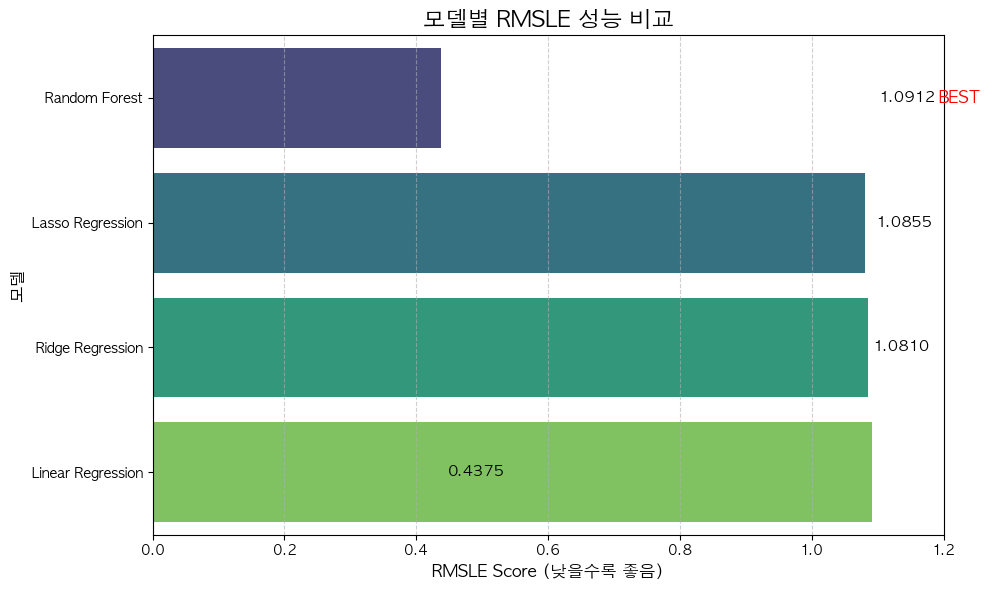

In [45]:



final_results = {
    "Linear Regression": lr_rmsle_score,
    "Ridge Regression": ridge_rmsle_score,
    "Lasso Regression": lasso_rmsle_score,
    "Random Forest": rf_rmsle_score
}

# 결과를 데이터프레임으로 변환하여 Seaborn으로 시각화 준비
results_df = pd.DataFrame(list(final_results.items()), columns=['Model', 'RMSLE'])
results_df = results_df.sort_values(by='RMSLE', ascending=True)

# 시각화 설정
plt.figure(figsize=(10, 6))
sns.barplot(x='RMSLE', y='Model', data=results_df, palette='viridis')

# 그래프 제목 및 축 라벨 설정
plt.title('모델별 RMSLE 성능 비교', fontsize=16)
plt.xlabel('RMSLE Score (낮을수록 좋음)', fontsize=12)
plt.ylabel('모델', fontsize=12)
plt.xlim(0, max(results_df['RMSLE']) * 1.1) # x축 범위 조정

# 각 막대에 RMSLE 값 표시 및 BEST 표시
for index, row in results_df.iterrows():
    plt.text(row['RMSLE'] + 0.01, index, f"{row['RMSLE']:.4f}", color='black', ha="left", va="center", fontsize=11)
    if index == 0:
         plt.text(row['RMSLE'] + 0.1, index, 'BEST', color='red', ha="left", va="center", fontsize=12, fontweight='bold')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()